In [104]:
!pip3 install category_encoders

In [105]:
!pip3 install xgboost

In [106]:
!pip3 install scipy

In [107]:
'''import libraries'''
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import classification_report

In [108]:
'''Load CSVs'''
energia_2021 = pd.read_csv('./datasets/energia_202109-202112.csv')
energia_2022 = pd.read_csv('./datasets/energia_202201-202212.csv')
meteo_2021 = pd.read_csv('./datasets/meteo_202109-202112.csv')
meteo_2022 = pd.read_csv('./datasets/meteo_202201-202212.csv')

teste_energia = pd.read_csv('./datasets/energia_202301-202304.csv')
teste_meteo = pd.read_csv('./datasets/meteo_202301-202304.csv')

## Análise dos Dados

#### Full Join dos datasets

In [109]:
energia_21 = energia_2021.copy()
energia_22 = energia_2022.copy() 
energia = pd.merge(energia_21, energia_22, how="outer", on=['Data', 'Hora','Normal (kWh)','Horário Económico (kWh)','Autoconsumo (kWh)','Injeção na rede (kWh)'])

In [110]:
meteo_21 = meteo_2021.copy()
meteo_22 = meteo_2022.copy() 
meteo = pd.merge(meteo_21, meteo_22, how="outer", on=['dt','dt_iso','city_name','temp', 'feels_like', 'temp_min', 'temp_max' , 'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'])

### Join dos datasets Energia e Meteorologia

In [111]:
energia['Data_Hora'] = energia['Data'] + ":" + energia['Hora'].astype(str)
energia['dt'] = energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [112]:
e_m = pd.merge(meteo, energia, how="inner", on= 'dt')

Teste

In [113]:
teste_energia['Data_Hora'] = teste_energia['Data'] + ":" + teste_energia['Hora'].astype(str)
teste_energia['dt'] = teste_energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [114]:
teste = pd.merge(teste_meteo, teste_energia, how="outer", on= 'dt')

In [115]:
teste.tail()

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,...,wind_speed,rain_1h,clouds_all,weather_description,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Data_Hora
2251,1680634800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023-04-04,19,0.953,0.000,0.012,2023-04-04:19
2252,1680638400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023-04-04,20,0.915,0.000,0.000,2023-04-04:20
2253,1680642000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023-04-04,21,0.479,0.000,0.000,2023-04-04:21
2254,1680645600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023-04-04,22,0.000,0.497,0.000,2023-04-04:22
2255,1680649200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023-04-04,23,0.000,0.487,0.000,2023-04-04:23


In [116]:
#for i in teste_meteo.columns:
    #sns.displot(teste_meteo, x=i, kde=True)

In [117]:
#teste_meteo.describe()

## Tratamento dos Dados

### Simplificação dos nomes das features

In [118]:
e_m.rename(columns={"dt": "Timestamp"}, inplace=True)
e_m.rename(columns={"temp": "Temperatura"}, inplace=True)
e_m.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
e_m.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
e_m.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
e_m.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
e_m.rename(columns={"humidity": "Humidade"}, inplace=True)
e_m.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
e_m.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
e_m.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
e_m.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
e_m.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
e_m.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
e_m.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
e_m.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

In [119]:
teste.rename(columns={"dt": "Timestamp"}, inplace=True)
teste.rename(columns={"temp": "Temperatura"}, inplace=True)
teste.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
teste.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
teste.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
teste.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
teste.rename(columns={"humidity": "Humidade"}, inplace=True)
teste.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
teste.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
teste.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
teste.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
teste.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
teste.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
teste.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
teste.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

### Remoção de features

In [120]:
e_m.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [121]:
teste.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [122]:
e_m.drop(['Data_Hora','dt_iso'], axis=1, inplace=True)

In [123]:
teste.drop(['Data_Hora','dt_iso'], axis=1, inplace=True)

### Alteração de datas

In [124]:
#def seconds_to_hours(x):
#    return x / 3600

In [125]:
#e_m['Timestamp'] = e_m['Timestamp'].apply(lambda x: seconds_to_hours(x))

In [126]:
#teste['Timestamp'] = teste['Timestamp'].apply(lambda x: seconds_to_hours(x))

#### Adicionar colunas a partir da data - Feature Engineering

Converter o tipo de dados da coluna 'timestamp' para datetime

In [127]:
e_m['Data'] = pd.to_datetime(e_m['Data'], format='%Y-%m-%d', errors='coerce')
assert e_m['Data'].isnull().sum() == 0, 'missing Data'
e_m['Data'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: Data, dtype: datetime64[ns]

In [128]:
teste['Data'] = pd.to_datetime(teste['Data'], format='%Y-%m-%d', errors='coerce')
assert teste['Data'].isnull().sum() == 0, 'missing Data'
teste['Data'].head()

0   2023-01-01
1   2023-01-01
2   2023-01-01
3   2023-01-01
4   2023-01-01
Name: Data, dtype: datetime64[ns]

Criação de várias colunas com as partes extraídas da Data

In [129]:
e_m['Ano'] = e_m['Data'].dt.year 
e_m['Mês'] = e_m['Data'].dt.month 
e_m['Dia'] = e_m['Data'].dt.day
e_m.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Ano,Mês,Dia
0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds,2021-09-29,0,0.0,0.0,0.0,NaN,2021,9,29
1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds,2021-09-29,1,0.0,0.0,0.0,NaN,2021,9,29
2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds,2021-09-29,2,0.0,0.0,0.0,NaN,2021,9,29
3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds,2021-09-29,3,0.0,0.0,0.0,NaN,2021,9,29
4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds,2021-09-29,4,0.0,0.0,0.0,NaN,2021,9,29


In [130]:
teste['Ano'] = teste['Data'].dt.year 
teste['Mês'] = teste['Data'].dt.month 
teste['Dia'] = teste['Data'].dt.day
teste.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Ano,Mês,Dia
0,1672531200,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,moderate rain,2023-01-01,0,0.0,0.467,0.0,2023,1,1
1,1672534800,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,moderate rain,2023-01-01,1,0.0,0.577,0.0,2023,1,1
2,1672538400,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,moderate rain,2023-01-01,2,0.0,0.346,0.0,2023,1,1
3,1672542000,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,moderate rain,2023-01-01,3,0.0,0.270,0.0,2023,1,1
4,1672545600,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,moderate rain,2023-01-01,4,0.0,0.252,0.0,2023,1,1


Criação de uma coluna 'Estação' e 'Parte do Dia'

In [131]:
# Create a dictionary to map the month to the corresponding season
estacoes = {1: 'Inverno', 2: 'Inverno', 3: 'Primavera', 4: 'Primavera', 5: 'Primavera', 6: 'Verão', 7: 'Verão', 8: 'Verão', 9: 'Outono', 10: 'Outono', 11: 'Outono', 12: 'Inverno'}

# Map the 'Mês' column to the corresponding season using the dictionary
#e_m['Estação'] = e_m['Mês'].map(estacoes)
#teste['Estação'] = teste['Mês'].map(estacoes)

In [132]:
def get_part_of_day(hour):
    if hour < 6:
        return 'Madrugada'
    elif hour < 12:
        return 'Manhã'
    elif hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

#e_m['Parte do Dia'] = e_m['Hora'].apply(get_part_of_day)
#teste['Parte do Dia'] = teste['Hora'].apply(get_part_of_day)

In [133]:
teste.nunique()

Timestamp              2256
Temperatura             889
Sensação Térmica       1007
Temperatura Mínima      169
Temperatura Máxima      174
Pressão Atmosférica      31
Humidade                 71
Velocidade Vento        512
Precipitação Média      120
Nebulosidade             99
Estado do Tempo           8
Data                     94
Hora                     24
Normal                  709
Horário Económico       490
Autoconsumo             485
Ano                       1
Mês                       4
Dia                      31
dtype: int64

In [134]:
e_m.drop(['Data','Ano'], axis=1, inplace=True)

In [135]:
teste.drop(['Data','Ano'], axis=1, inplace=True)

### Converter tipos de dados categóricos para numéricos

#### Injeção na Rede

In [136]:
#e_m['Injeção na Rede'] = pd.factorize(e_m['Injeção na Rede'])[0] + 1

In [137]:
from sklearn.preprocessing import LabelEncoder    

In [138]:
lb_make = LabelEncoder()
e_m['Injeção na Rede'] = lb_make.fit_transform(e_m['Injeção na Rede'])

#### Estado do Tempo

In [139]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#e_m = encoder.fit_transform(e_m)

In [140]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#teste = encoder.fit_transform(teste)

In [141]:
lb_make = LabelEncoder()
e_m['Estado do Tempo'] = lb_make.fit_transform(e_m['Estado do Tempo'])

In [142]:
lb_make = LabelEncoder()
teste['Estado do Tempo'] = lb_make.fit_transform(teste['Estado do Tempo'])

#### Estação do Ano

In [143]:
#lb_make = LabelEncoder()
#e_m['Estação'] = lb_make.fit_transform(e_m['Estação'])

In [144]:
#lb_make = LabelEncoder()
#teste['Estação'] = lb_make.fit_transform(teste['Estação'])

#### Parte do Dia

In [145]:
#lb_make = LabelEncoder()
#e_m['Parte do Dia'] = lb_make.fit_transform(e_m['Parte do Dia'])

In [146]:
#lb_make = LabelEncoder()
#teste['Parte do Dia'] = lb_make.fit_transform(teste['Parte do Dia'])

### Normalização

In [147]:
from sklearn import preprocessing

In [148]:
e_m.describe()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Mês,Dia
count,1.101600e+04,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,2284.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,1.652701e+09,16.182991,15.826868,14.195064,17.288098,1018.396605,76.570715,2.672039,0.896642,54.000908,4.374818,11.500000,0.202278,0.159714,0.117314,3.227487,7.433551,15.803922
std,1.144868e+07,5.756972,6.264860,4.956014,6.164689,6.203379,16.268260,1.476158,1.079381,40.553002,2.403911,6.922501,0.349478,0.271792,0.176762,1.346130,3.578335,8.835905
min,1.632874e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,19.000000,0.060000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.642787e+09,12.080000,11.507500,10.720000,12.890000,1015.000000,66.000000,1.620000,0.210000,7.000000,3.000000,5.750000,0.000000,0.000000,0.000000,3.000000,4.000000,8.000000
50%,1.652701e+09,15.625000,15.230000,14.230000,16.260000,1018.000000,81.000000,2.400000,0.460000,60.000000,5.000000,11.500000,0.000000,0.000000,0.000000,4.000000,8.000000,16.000000
75%,1.662614e+09,19.270000,19.260000,17.490000,20.340000,1022.000000,91.000000,3.420000,1.092500,98.000000,7.000000,17.250000,0.314000,0.288000,0.227000,4.000000,11.000000,23.000000
max,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,100.000000,11.100000,7.450000,100.000000,7.000000,23.000000,3.251000,6.978000,1.192000,4.000000,12.000000,31.000000


In [149]:
from scipy.stats import zscore

In [150]:
#numeric_cols = e_m.select_dtypes(include=[np.number]).columns
#e_m[numeric_cols].apply(zscore)

In [151]:
#numeric_cols = teste.select_dtypes(include=[np.number]).columns
#teste[numeric_cols].apply(zscore)

In [152]:
#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#e_m[['Timestamp']] = min_max_scaler.fit_transform(e_m[['Timestamp']])
#e_m[['Temperatura']] = min_max_scaler.fit_transform(e_m[['Temperatura']])
#e_m[['Sensação Térmica']] = min_max_scaler.fit_transform(e_m[['Sensação Térmica']])
#e_m[['Temperatura Mínima']] = min_max_scaler.fit_transform(e_m[['Temperatura Mínima']])
#e_m[['Temperatura Máxima']] = min_max_scaler.fit_transform(e_m[['Temperatura Máxima']])
#e_m[['Pressão Atmosférica']] = min_max_scaler.fit_transform(e_m[['Pressão Atmosférica']])
#e_m[['Humidade']] = min_max_scaler.fit_transform(e_m[['Humidade']])
#Velocidade Vento
#e_m[['Velocidade Vento']] = min_max_scaler.fit_transform(e_m[['Velocidade Vento']])

#Precipitação Média
#e_m[['Precipitação Média']] = min_max_scaler.fit_transform(e_m[['Precipitação Média']])
#e_m[['Nebulosidade']] = min_max_scaler.fit_transform(e_m[['Nebulosidade']])

#e_m[['Estado do Tempo']] = min_max_scaler.fit_transform(e_m[['Estado do Tempo']])
#e_m[['Normal']] = min_max_scaler.fit_transform(e_m[['Normal']])
#e_m[['Horário Económico']] = min_max_scaler.fit_transform(e_m[['Horário Económico']])
#e_m[['Autoconsumo']] = min_max_scaler.fit_transform(e_m[['Autoconsumo']])


In [153]:
#teste[['Timestamp']] = min_max_scaler.fit_transform(teste[['Timestamp']])
#teste[['Temperatura']] = min_max_scaler.fit_transform(teste[['Temperatura']])
#teste[['Sensação Térmica']] = min_max_scaler.fit_transform(teste[['Sensação Térmica']])
#teste[['Temperatura Mínima']] = min_max_scaler.fit_transform(teste[['Temperatura Mínima']])
#teste[['Temperatura Máxima']] = min_max_scaler.fit_transform(teste[['Temperatura Máxima']])
#teste[['Pressão Atmosférica']] = min_max_scaler.fit_transform(teste[['Pressão Atmosférica']])
#teste[['Humidade']] = min_max_scaler.fit_transform(teste[['Humidade']])
#teste[['Velocidade Vento']] = min_max_scaler.fit_transform(teste[['Velocidade Vento']])
#teste[['Precipitação Média']] = min_max_scaler.fit_transform(teste[['Precipitação Média']])
#teste[['Nebulosidade']] = min_max_scaler.fit_transform(teste[['Nebulosidade']])
#teste[['Estado do Tempo']] = min_max_scaler.fit_transform(teste[['Estado do Tempo']])
#teste[['Normal']] = min_max_scaler.fit_transform(teste[['Normal']])
#teste[['Horário Económico']] = min_max_scaler.fit_transform(teste[['Horário Económico']])
#teste[['Autoconsumo']] = min_max_scaler.fit_transform(teste[['Autoconsumo']])

### Tratamento de Outliers

In [154]:
#for column in e_m.columns:
#    if column not in  ['Injeção na Rede','Dia','Mês','Hora','Nebulosidade','Estado do Tempo','Precipitação Média']:
#        sns.catplot( x="Injeção na Rede", y=column, data=e_m, kind="box", height=8, aspect=2.5)
#        plt.show()

In [155]:
from scipy.stats.mstats import winsorize

In [156]:
def get_outliers(lower,upper,field):
    Q1 = e_m[field].quantile(0.25)
    Q3 = e_m[field].quantile(0.75)
    IQR = Q3-Q1

    lower_lim = Q1 - lower * IQR
    upper_lim = Q3 + upper * IQR

    out_low = (e_m[field]<lower_lim)
    out_up = (e_m[field]>upper_lim)

    return [out_low,out_up]

##### Temperatura

In [157]:
#e_m['Temperatura'] = winsorize(e_m['Temperatura'], (0.000182,0.02442))

##### Sensação Térmica

In [158]:
#e_m['Sensação Térmica'] = winsorize(e_m['Sensação Térmica'], (0.0003,0.0242))

##### Temperatura Mínima

In [159]:
outliers_low, outliers_up = get_outliers(1.46,1.4,'Temperatura Mínima')

median = e_m['Temperatura Mínima'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Temperatura Mínima'] = median

##### Temperatura Máxima

In [160]:
outliers_low, outliers_up = get_outliers(1.0,1.0,'Temperatura Máxima')

In [161]:
e_m.loc[outliers_low | outliers_up, 'Pressão Atmosférica'] = np.nan

In [162]:
#e_m = e_m[~(outliers_low|outliers_up)]

##### Pressão Atmosférica

In [163]:
#e_m['Pressão Atmosférica'] = winsorize(e_m['Pressão Atmosférica'], (0.0258,0.0025))

In [164]:
outliers_low, outliers_up = get_outliers(1.5,1.2,'Pressão Atmosférica')

In [165]:
e_m.loc[outliers_low | outliers_up, 'Pressão Atmosférica'] = np.nan

##### Humidade

In [166]:
#e_m['Humidade'] = winsorize(e_m['Humidade'], (0.0058,0.0))

In [167]:
outliers_low, outliers_up = get_outliers(0.7,1.5,'Humidade')

In [168]:
e_m.loc[outliers_low | outliers_up, 'Humidade'] = np.nan

##### Velocidade Vento

In [169]:
outliers_low, outliers_up = get_outliers(1.5,1.0,'Velocidade Vento')

#median = e_m['Velocidade Vento'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
#e_m.loc[outliers_low | outliers_up, 'Velocidade Vento'] = median

In [170]:
e_m.loc[outliers_low | outliers_up, 'Velocidade Vento'] = np.nan

##### Precipitação Média

##### Normal

In [171]:
#e_m['Normal'] = winsorize(e_m['Normal'], (0.0,0.0683))

In [172]:
#outliers_low, outliers_up = get_outliers(1.0,1.5,'Normal')

In [173]:
#e_m.loc[outliers_low | outliers_up, 'Normal'] = np.nan

c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


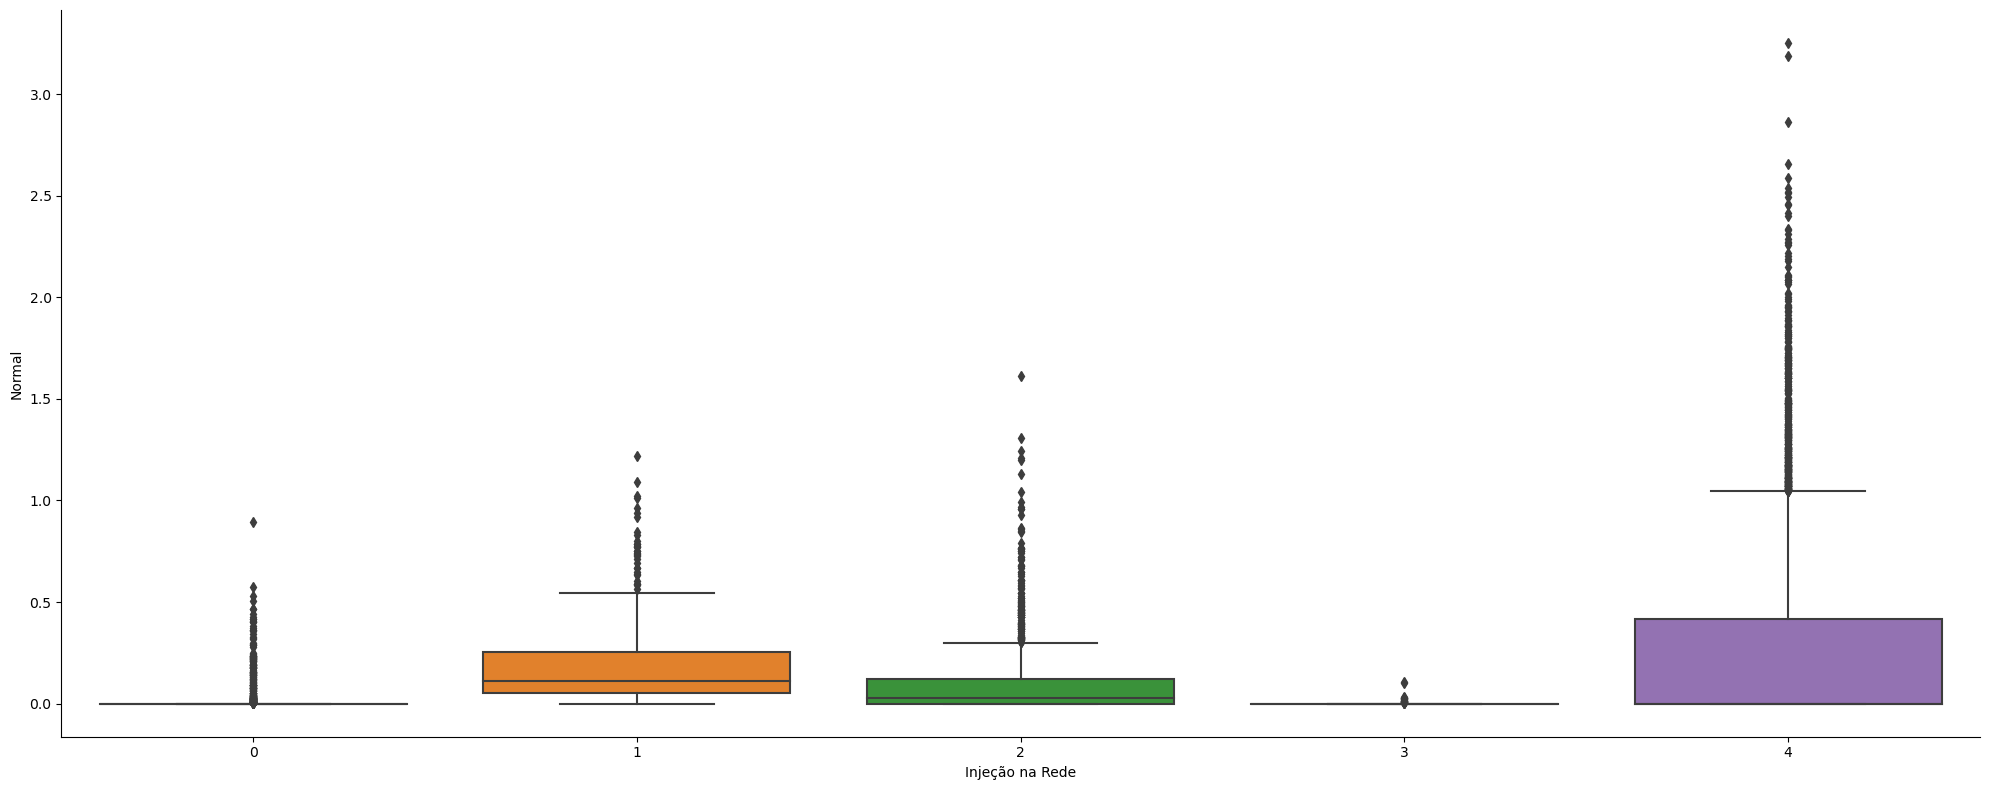

In [174]:
sns.catplot( x="Injeção na Rede", y='Normal', data=e_m, kind="box", height=8, aspect=2.5)
plt.show()

##### Horário Económico

In [175]:
#outliers_low, outliers_up = get_outliers(1.5,1.3,'Horário Económico')

median = e_m['Horário Económico'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
#e_m.loc[outliers_low | outliers_up, 'Horário Económico'] = median

In [176]:
outliers_low, outliers_up = get_outliers(0.5,1.5,'Horário Económico')

In [177]:
e_m.loc[outliers_low | outliers_up, 'Horário Económico'] = np.nan

c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


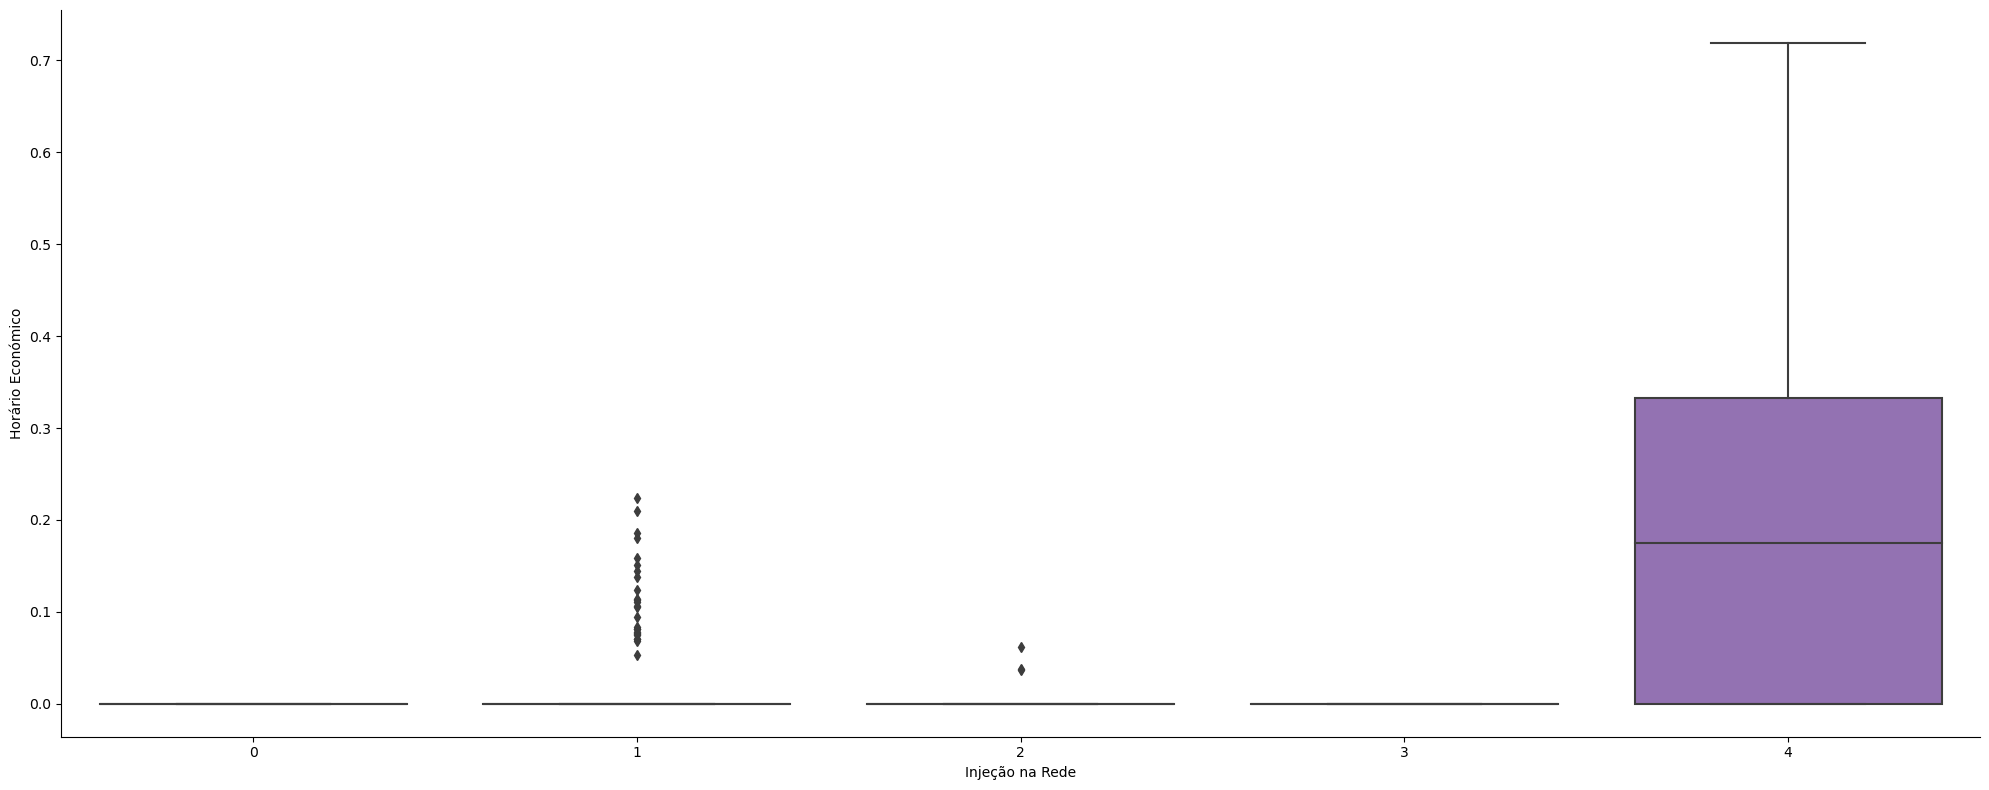

In [178]:
sns.catplot( x="Injeção na Rede", y='Horário Económico', data=e_m, kind="box", height=8, aspect=2.5)
plt.show()

##### Autoconsumo

In [179]:
#outliers_low, outliers_up = get_outliers(1.5,1.23,'Autoconsumo')

In [180]:
#e_m = e_m[~(outliers_low|outliers_up)]

In [181]:
outliers_low, outliers_up = get_outliers(1.0,1.0,'Autoconsumo')

In [182]:
e_m.loc[outliers_low | outliers_up, 'Autoconsumo'] = np.nan

c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


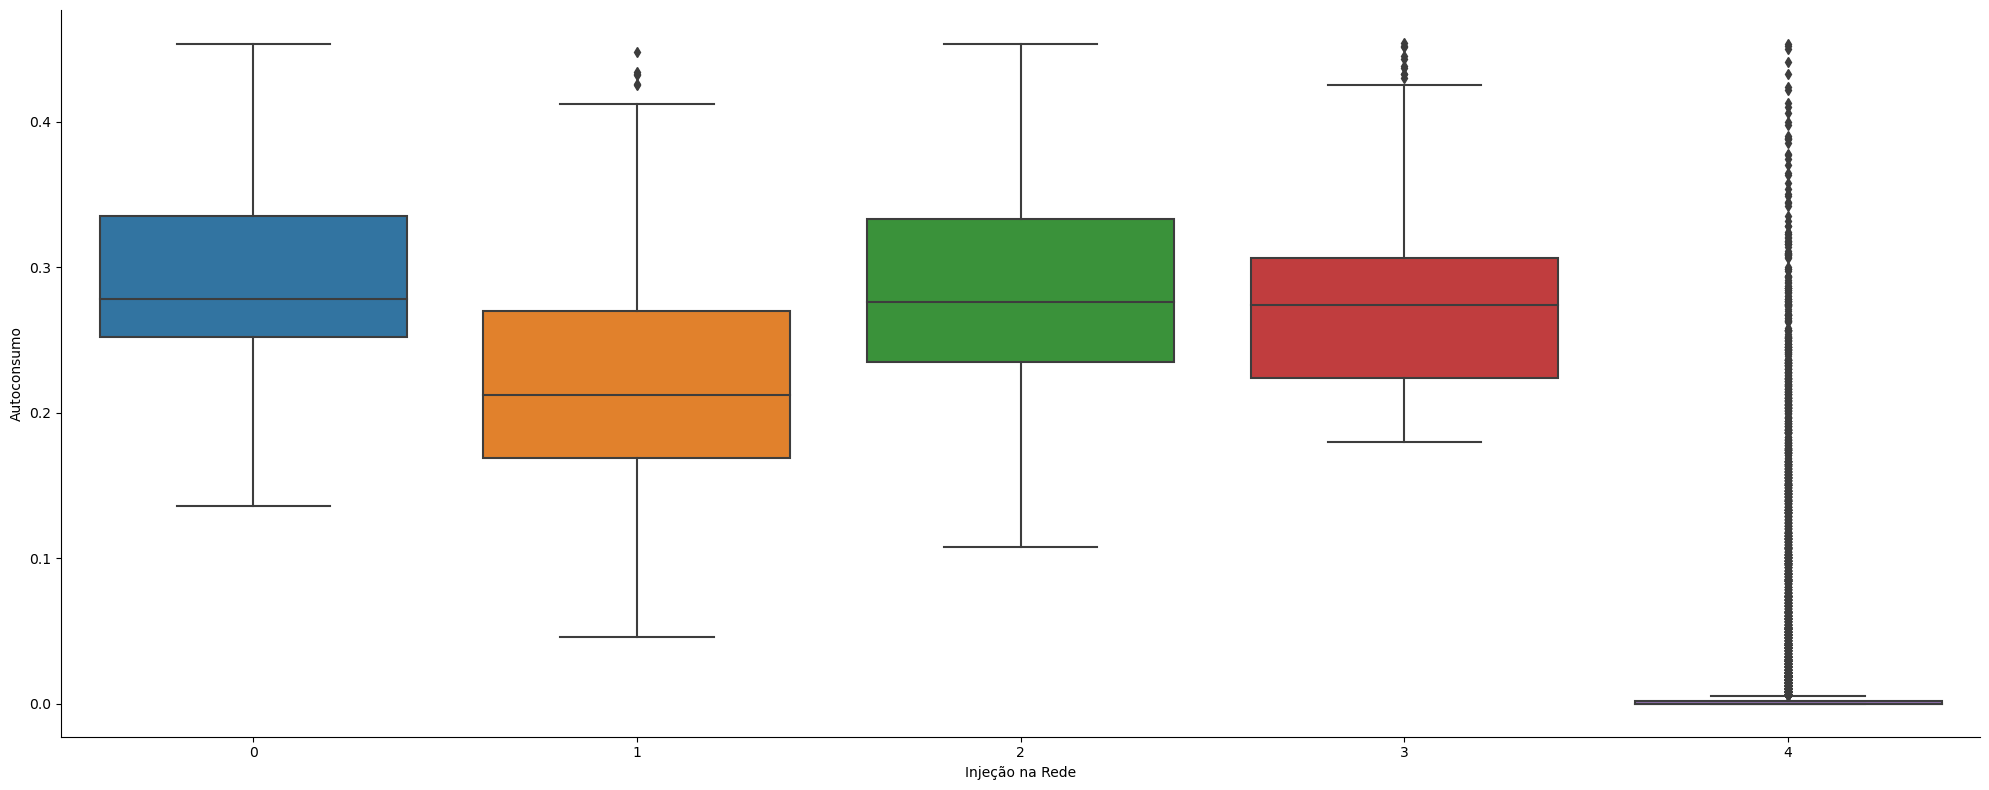

In [183]:
sns.catplot( x="Injeção na Rede", y='Autoconsumo', data=e_m, kind="box", height=8, aspect=2.5)
plt.show()

### Tratamento de Missing Values

##### Temperatura

In [184]:
#teste['Temperatura'].fillna(teste['Temperatura'].median(), inplace=True)

##### Sensação Térmica

In [185]:
#teste['Sensação Térmica'].fillna(teste['Sensação Térmica'].median(), inplace=True)

##### Temperatura Mínima

In [186]:
#teste['Temperatura Mínima'].fillna(teste['Temperatura Mínima'].median(), inplace=True)

##### Temperatura Máxima

In [187]:
#teste['Temperatura Máxima'].fillna(teste['Temperatura Máxima'].median(), inplace=True)

##### Pressão Atmosférica

In [188]:
#teste['Pressão Atmosférica'].fillna(teste['Pressão Atmosférica'].median(), inplace=True)

##### Humidade

In [189]:
#teste['Humidade'].fillna(teste['Humidade'].median(), inplace=True)

##### Velocidade Vento

In [190]:
#teste['Velocidade Vento'].fillna(teste['Velocidade Vento'].median(), inplace=True)

##### Precipitação Média

In [191]:
#e_m.drop(['Precipitação Média'], axis=1, inplace=True)

In [192]:
#teste.drop(['Precipitação Média'], axis=1, inplace=True)

##### Nebulosidade

In [193]:
#teste['Nebulosidade'].fillna(teste['Nebulosidade'].median(), inplace=True)

### Exploratory Data Analysis 

<Axes: >

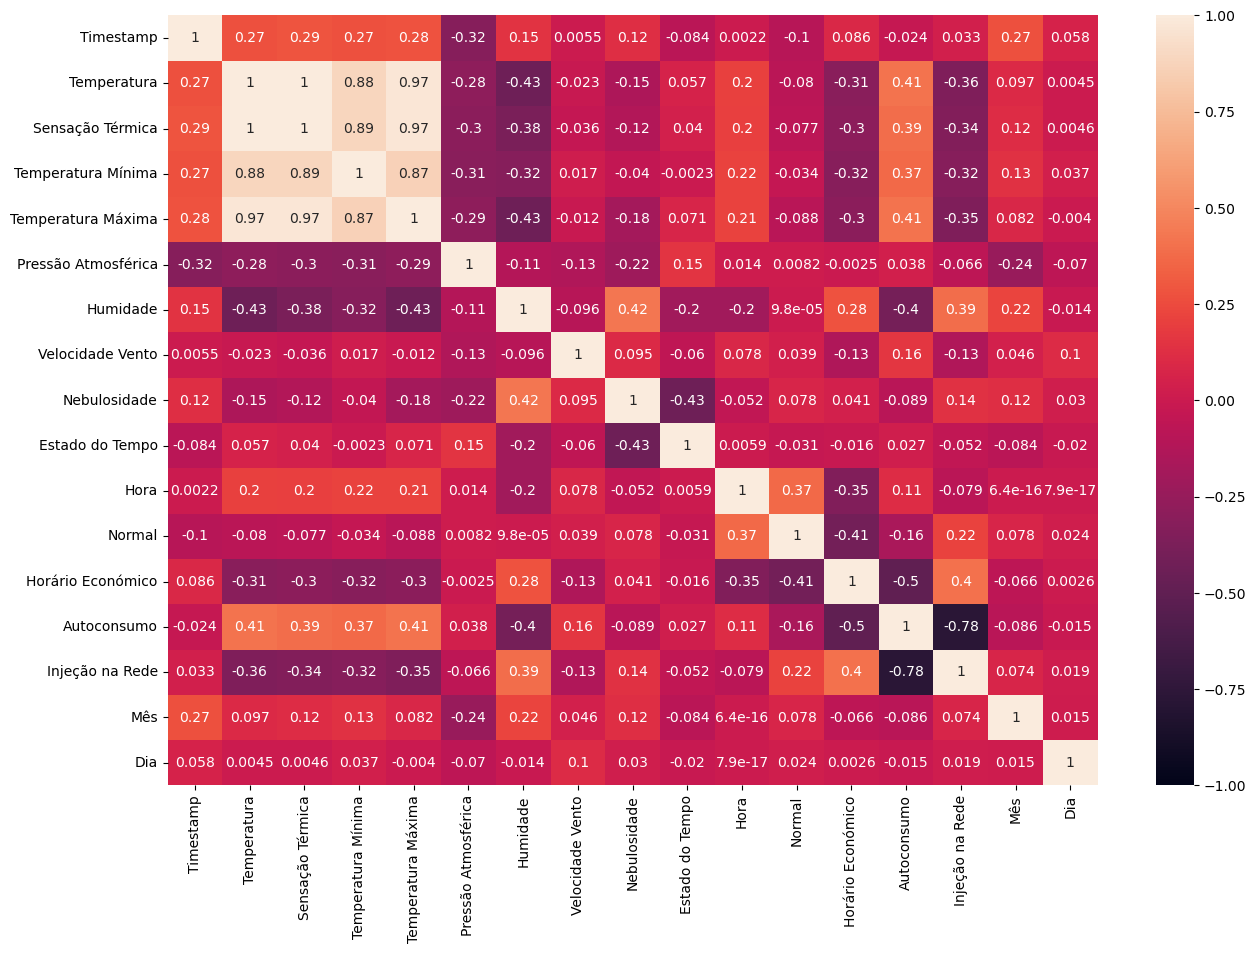

In [194]:
fig = plt.figure(figsize = (15,10))
incidents_corr = e_m.corr(method = 'pearson')
sns.heatmap(e_m.corr(),vmin=-1,annot = True)

Drop das features muito correlacionadas

In [195]:
e_m.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)
teste.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)


In [196]:
#e_m.drop(['Estado do Tempo','Dia','Pressão Atmosférica','Velocidade Vento','Temperatura','Temperatura Mínima','Sensação Térmica'], axis=1, inplace=True)
#teste.drop(['Estado do Tempo','Dia','Pressão Atmosférica','Velocidade Vento','Temperatura','Temperatura Mínima','Sensação Térmica'], axis=1, inplace=True)

                Feature  Importance
13          Autoconsumo    0.263019
12    Horário Económico    0.198720
11               Normal    0.143007
10                 Hora    0.078064
6              Humidade    0.060149
4    Temperatura Máxima    0.050546
0             Timestamp    0.028123
8          Nebulosidade    0.027743
14                  Mês    0.025800
1           Temperatura    0.022674
3    Temperatura Mínima    0.019157
2      Sensação Térmica    0.019125
7      Velocidade Vento    0.018039
5   Pressão Atmosférica    0.016807
15                  Dia    0.014567
9       Estado do Tempo    0.014460

## Modelos

In [197]:
X = e_m.drop(['Injeção na Rede'], axis=1)   # input features - tudo exceto o target
y = e_m['Injeção na Rede'].to_frame()       # target feature - Injeção na Rede

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 4626 to 10629
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            2204 non-null   int64  
 1   Temperatura Máxima   2204 non-null   float64
 2   Pressão Atmosférica  1981 non-null   float64
 3   Humidade             2046 non-null   float64
 4   Velocidade Vento     2075 non-null   float64
 5   Nebulosidade         2204 non-null   int64  
 6   Estado do Tempo      2204 non-null   int32  
 7   Hora                 2204 non-null   int64  
 8   Normal               2204 non-null   float64
 9   Horário Económico    2143 non-null   float64
 10  Autoconsumo          2104 non-null   float64
 11  Mês                  2204 non-null   int32  
 12  Dia                  2204 non-null   int32  
dtypes: float64(7), int32(3), int64(3)
memory usage: 215.2 KB


### XGBoost

Definir hiperparêmetros

In [199]:
param_grid = {
    'learning_rate': [0.01,0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1]
}

In [200]:
#bst = xgb.XGBClassifier(scale_pos_weight={4:1, 1:2}, objective='binary:logistic', random_state = 2023)
bst = xgb.XGBClassifier(objective='multi:softmax', random_state = 2023)

In [201]:
# Use GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(bst, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Obtenha os melhores hiperparâmetros e o modelo ajustado
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


In [202]:
# create model instance
bst = xgb.XGBClassifier(**best_params, objective='multi:softmax', random_state=2023)
# fit model
bst.fit(X_train, y_train)
# make predictions
predictions_xgb = bst.predict(X_test)

In [203]:
# Avalia o overfit - se o f1 score for menor que a accuracy
print(accuracy_score(y_test, predictions_xgb))                   
print(precision_score(y_test, predictions_xgb, average='micro')) 
print(recall_score(y_test, predictions_xgb, average='micro')) 

0.8892921960072595
0.8892921960072595
0.8892921960072595


In [204]:
importances = bst.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
10          Autoconsumo    0.327026
9     Horário Económico    0.202414
8                Normal    0.138685
7                  Hora    0.079917
3              Humidade    0.054903
1    Temperatura Máxima    0.044029
5          Nebulosidade    0.029439
0             Timestamp    0.028243
11                  Mês    0.026235
2   Pressão Atmosférica    0.020462
4      Velocidade Vento    0.018579
6       Estado do Tempo    0.015434
12                  Dia    0.014634


In [205]:
print(classification_report(y_test,predictions_xgb))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       215
           1       0.48      0.26      0.34        91
           2       0.65      0.60      0.63       214
           3       0.79      0.85      0.82       116
           4       0.97      0.98      0.98      1568

    accuracy                           0.89      2204
   macro avg       0.72      0.70      0.70      2204
weighted avg       0.88      0.89      0.88      2204



# Guardar Submissão

In [206]:
# Fazer previsão com o BST
predictions = bst.predict(teste)

# Adicionar header
submission = pd.DataFrame(predictions, columns = ["Injeção na Rede"]).head(2256)
submission.index.name = 'RowId'
submission.index += 1
submission.rename(columns={'Injeção na Rede': 'Result'}, inplace=True)

# Trocar para valores categóricos
submission['Result'] = submission['Result'].replace({4:'None', 1:'Low', 2:'Medium', 0:'High', 3:'Very_High'})

#Passar para um ficheiro CSV
submission.to_csv('submission_xgb.csv', index=True, header=True)